# Acquisition example

In this notebook we demonstrate a simple Bayesian optimization loop

## Initialize a problem

We will initialize the ZDT1 benchmark with two-dimensional inputs and outputs.

In [1]:
import torch

from botorch.utils.sampling import draw_sobol_samples
from botorch.test_functions.multi_objective import ZDT1

In [2]:
d = 2
M = 2
n = 6

problem = ZDT1(dim=d, num_objectives=M, noise_std=0, negate=True)
bounds = problem.bounds

# `n x d`
train_X = draw_sobol_samples(bounds=bounds, n=n, q=1, seed=123).squeeze(-2)
train_Y = problem(train_X)

## Acquire

We now initialize and optimize some acquisition functions. All acquisition functions apart from the PES are optimized using the multi-start L-BFGS algorithm implemented by BoTorch's optimize_acqf method. We find that the automatic gradient inferred for the PES acquisition function to be unreliable, hence we estimate the gradients using finite differences---more details are in the preamble of jes.acquisition.pes.

In [3]:
import time
from jes.utils.bo_loop import bo_loop
from botorch.utils.transforms import unnormalize, normalize

In [4]:
standard_bounds = torch.zeros(2, d)
standard_bounds[1] = 1.0
algos = ["ts", "parego", "ehvi", "jes_lb", "mes_lb", "pes"]
x_list = []

In [5]:
for a in algos:
    init_time = time.time()
    x = bo_loop(
        train_X=normalize(train_X, bounds),
        train_Y=train_Y,
        num_outputs=M,
        bounds=standard_bounds,
        acquisition_type=a,
        num_pareto_samples=10,
        num_pareto_points=10,
        num_greedy=10,
        num_samples=128,
        num_restarts=10,
        raw_samples=1000,
        batch_size=1
    )
    x = unnormalize(x, bounds)
    x_list = x_list + [x]
    print("Algo = {}, Time taken = {:4.2f}".format(a, time.time() - init_time))

Algo = ts, Time taken = 1.79
Algo = parego, Time taken = 0.59
Algo = ehvi, Time taken = 0.43
Algo = jes_lb, Time taken = 16.09
Algo = mes_lb, Time taken = 15.23
Algo = pes, Time taken = 64.14


## Plot

In [6]:
import matplotlib.pyplot as plt

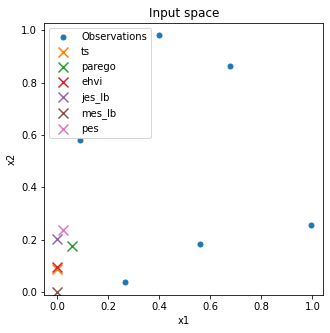

In [7]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(train_X[:, 0], train_X[:, 1], marker=".", s=100, label="Observations")
    
for i, a in enumerate(algos):
    x = x_list[i]
    plt.scatter(x[0, 0], x[0, 1], marker="x", s=100, label=a)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Input space")
plt.legend()
plt.show()